In [106]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.ndimage import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imresize, imsave

In [6]:
path = './trainset/Cat/1.Cat.jpg'
img = plt.imread(path)
img

array([[[ 41,  48,  41],
        [ 32,  37,  31],
        [ 48,  53,  47],
        ...,
        [ 71,  85, 111],
        [ 74,  90, 115],
        [ 75,  91, 116]],

       [[ 46,  53,  46],
        [ 36,  43,  36],
        [ 51,  56,  50],
        ...,
        [ 73,  85, 109],
        [ 77,  92, 115],
        [ 84,  98, 124]],

       [[ 49,  56,  49],
        [ 42,  48,  44],
        [ 50,  56,  52],
        ...,
        [ 67,  78, 100],
        [ 76,  87, 109],
        [ 88, 100, 122]],

       ...,

       [[ 24,  22,  23],
        [ 23,  21,  22],
        [ 23,  21,  22],
        ...,
        [ 62,  52,  43],
        [ 59,  49,  40],
        [ 64,  54,  45]],

       [[ 22,  20,  21],
        [ 22,  20,  21],
        [ 22,  20,  21],
        ...,
        [ 68,  58,  49],
        [ 68,  58,  49],
        [ 69,  59,  50]],

       [[ 25,  23,  24],
        [ 25,  23,  24],
        [ 26,  24,  25],
        ...,
        [ 66,  56,  47],
        [ 67,  57,  48],
        [ 63,  53,  44]]

In [10]:
imgarr.shape

(64, 64, 3)

In [6]:
#Cat's label is 0 and dogs' label is 1 here
train_data_x = []
train_data_y = np.zeros([19998,])
train_data_y[:9999] = 0
train_data_y[9999:] = 1
j = 0
for i in range(1, 10000):
    img_path = './trainset/Cat/%d.Cat.jpg'%(i)
    img = plt.imread(img_path)
    #for grey images
    if len(img.shape) != 3:
            img = np.repeat(np.expand_dims(img, axis=-1), 3, axis=-1)
    #imsave('./trainset/Cat/%d.Cat.jpg'%(i), img)
    train_data_x.append(img)

for i in range(1, 10000):
    img_path = './trainset/Dog/%d.Dog.jpg'%(i)
    img = plt.imread(img_path)
    #for grey images
    if len(img.shape) != 3:
            img = np.repeat(np.expand_dims(img, axis=-1), 3, axis=-1)
    #imsave('./trainset/Dog/%d.Dog.jpg'%(i), img)
    train_data_x.append(img)
    
train_data_x = np.stack(train_data_x, axis=0).astype(np.float)


In [7]:
print (train_data_x.shape, train_data_y.shape)

(19998, 64, 64, 3) (19998,)


In [8]:
#shuffle data
train_data_x_shuffle, train_data_y_shuffle = shuffle(train_data_x, train_data_y)
means = [np.mean(train_data_x_shuffle[:,:,:,0]),
         np.mean(train_data_x_shuffle[:,:,:,1]), np.mean(train_data_x_shuffle[:,:,:,2])]
#subtracted by means

# train_data_x_shuffle[:,:,:,0] -= means[0]
# train_data_x_shuffle[:,:,:,1] -= means[1]
# train_data_x_shuffle[:,:,:,2] -= means[2]

In [9]:
train_x = train_data_x_shuffle[2500:]
train_y = train_data_y_shuffle[2500:]
valid_x = train_data_x_shuffle[:2500]
valid_y = train_data_y_shuffle[:2500]

In [10]:
save_path_x = './trainset_x'
save_path_y = './trainset_y'
save_path_x_valid = './validset_x'
save_path_y_valid = './validset_y'
np.save(save_path_x, train_x)
np.save(save_path_y, train_y)

In [11]:
np.save(save_path_x_valid, valid_x)
np.save(save_path_y_valid, valid_y)

In [12]:
save_path_x = './trainset_x'
save_path_y = './trainset_y'
save_path_x_valid = './validset_x'
save_path_y_valid = './validset_y'
train_x = np.load(save_path_x + '.npy')
train_y = np.load(save_path_y + '.npy')
valid_x = np.load(save_path_x_valid + '.npy')
valid_y = np.load(save_path_y_valid + '.npy')

# Pytorch

In [89]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/cat_dog_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

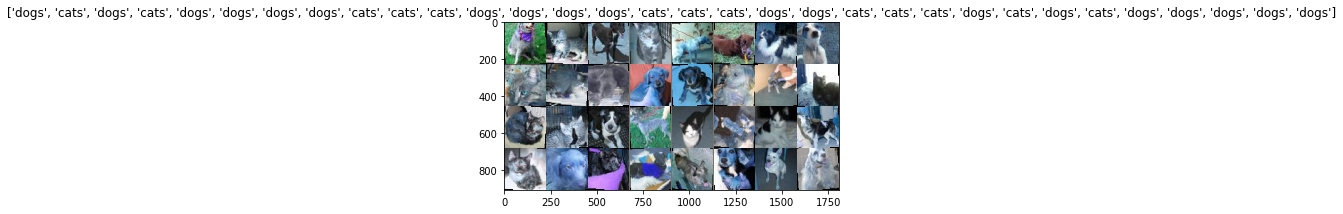

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [109]:
import torch.nn as nn
from torch.autograd import Variable

class CNN(nn.Module):
    """Convnet Classifier"""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=18, kernel_size=(3, 3), padding=1),
            #nn.Dropout(p=0.5),
            #nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 2
            nn.Conv2d(in_channels=18, out_channels=36, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            #nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 3
            nn.Conv2d(in_channels=36, out_channels=72, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            #nn.BatchNorm2d(72),
            nn.ReLU(),

            # Layer 4
            nn.Conv2d(in_channels=72, out_channels=72, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            #nn.BatchNorm2d(72),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 5
            nn.Conv2d(in_channels=72, out_channels=144, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            #nn.BatchNorm2d(144),
            nn.ReLU(),

            # Layer 6
            nn.Conv2d(in_channels=144, out_channels=144, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            #nn.BatchNorm2d(144),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        )

        # Linear units
        self.linear = nn.Sequential(
            nn.Linear(144 * 14 * 14, 144 * 14 * 14),
            #nn.BatchNorm1d(144 * 4 * 4),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.Linear(144 * 14 * 14, 500),
            #nn.BatchNorm1d(500),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.Linear(500, 2)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.conv(x)
        #print(x.shape)
        x = x.view(-1, 144*14*14)
        #print(x.shape)
        x = self.linear(x)
        m = nn.Softmax()
        x = m(x)
        #print(x.shape)
        #print(x.shape)
        return x

In [110]:
model = CNN()
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [111]:
num_epochs = 50

In [ ]:
# Train the model
total_step = len(dataloaders['train'])
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloaders['train']):
        # Run the forward pass
        outputs = model(images)
    
        
        #print (outputs.shape)
        #print (labels.shape)
        loss = criterion(outputs, labels)
        
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

/Users/yutongyan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/50], Step [1/547], Loss: 0.6870, Accuracy: 68.75%


In [106]:
def train_model(model, criterion, optimizer,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [108]:
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001)
model = train_model(model, criterion, optimizer_ft,
                       num_epochs=50)

Epoch 0/49
----------


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.6/multiprocessin

KeyboardInterrupt: 

Keras

In [36]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
for i in range(train_x.shape[0]):
    if (train_y[i] == 0):
        cv2.imwrite('data/train_data/cats/%d.jpg'%(i), train_x[i])
    else:
        cv2.imwrite('data/train_data/dogs/%d.jpg'%(i), train_x[i])
for i in range(valid_x.shape[0]):
    if (valid_y[i] == 0):
        cv2.imwrite('data/valid_data/cats/%d.jpg'%(i), valid_x[i])
    else:
        cv2.imwrite('data/valid_data/dogs/%d.jpg'%(i), valid_x[i])

1.0


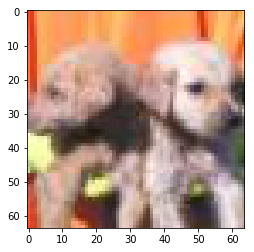

In [17]:
#test
num_test = 1100
img_test = train_x[num_test]
imgplot = plt.imshow(img_test/255)
print (train_y[num_test])

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, regularizers
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [24]:
#test datagen
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('./trainset/Cat/1.Cat.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 64, 64)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 64, 64)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [49]:
model = Sequential()
model.add(Conv2D(8, (3, 3), input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=0.05),
              metrics=['accuracy'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
activation_29 (Activation)   (None, 62, 62, 8)         0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 8)         584       
_________________________________________________________________
activation_30 (Activation)   (None, 29, 29, 8)         0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 16)        1168      
__________

In [51]:
batch_size = 32
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/cat_dog_data/train',  # this is the target directory
        target_size=(64, 64),  # all images will be resized to 64X64
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/cat_dog_data/val',
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='binary')

Found 17498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [52]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('first_try_01.h5')  # always save your weights after training or during training

Epoch 1/200
62/62 [==============================] - 6s 99ms/step - loss: 0.6941 - acc: 0.5005 - val_loss: 0.6954 - val_acc: 0.4813
Epoch 2/200
62/62 [==============================] - 5s 87ms/step - loss: 0.6920 - acc: 0.5055 - val_loss: 0.6924 - val_acc: 0.5175
Epoch 3/200
62/62 [==============================] - 5s 87ms/step - loss: 0.6931 - acc: 0.5020 - val_loss: 0.6914 - val_acc: 0.5413
Epoch 4/200
62/62 [==============================] - 5s 87ms/step - loss: 0.6925 - acc: 0.5040 - val_loss: 0.6915 - val_acc: 0.5583
Epoch 5/200
62/62 [==============================] - 5s 86ms/step - loss: 0.6902 - acc: 0.5216 - val_loss: 0.6945 - val_acc: 0.4800
Epoch 6/200
62/62 [==============================] - 5s 88ms/step - loss: 0.6910 - acc: 0.5292 - val_loss: 0.6877 - val_acc: 0.5813
Epoch 7/200
62/62 [==============================] - 6s 89ms/step - loss: 0.6911 - acc: 0.5136 - val_loss: 0.6877 - val_acc: 0.5738
Epoch 8/200
62/62 [==============================] - 5s 87ms/step - loss: 0.

KeyboardInterrupt: 

In [76]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train_data',  # this is the target directory
        target_size=(64, 64),  # all images will be resized to 64X64
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/valid_data',
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='binary')

Found 17498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [77]:
model1.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model1.save_weights('second_try.h5')

Epoch 1/50
62/62 [==============================] - 12s 186ms/step - loss: 0.6845 - acc: 0.5615 - val_loss: 0.6764 - val_acc: 0.5938
Epoch 2/50
62/62 [==============================] - 12s 198ms/step - loss: 0.6847 - acc: 0.5333 - val_loss: 0.6771 - val_acc: 0.6125
Epoch 3/50
62/62 [==============================] - 12s 191ms/step - loss: 0.6800 - acc: 0.5902 - val_loss: 0.6698 - val_acc: 0.6288
Epoch 4/50
62/62 [==============================] - 12s 200ms/step - loss: 0.6780 - acc: 0.5691 - val_loss: 0.6732 - val_acc: 0.6192
Epoch 5/50
62/62 [==============================] - 11s 184ms/step - loss: 0.6786 - acc: 0.5716 - val_loss: 0.6639 - val_acc: 0.6250
Epoch 6/50
62/62 [==============================] - 12s 189ms/step - loss: 0.6807 - acc: 0.5701 - val_loss: 0.6629 - val_acc: 0.6050
Epoch 7/50
62/62 [==============================] - 12s 188ms/step - loss: 0.6825 - acc: 0.5625 - val_loss: 0.6687 - val_acc: 0.6231
Epoch 8/50
62/62 [==============================] - 12s 189ms/step - 

In [78]:
model1.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model1.save_weights('second_try.h5')

Epoch 1/50
62/62 [==============================] - 12s 189ms/step - loss: 0.5830 - acc: 0.6925 - val_loss: 0.5276 - val_acc: 0.7288
Epoch 2/50
62/62 [==============================] - 11s 184ms/step - loss: 0.5655 - acc: 0.7182 - val_loss: 0.5087 - val_acc: 0.7475
Epoch 3/50
62/62 [==============================] - 11s 183ms/step - loss: 0.5588 - acc: 0.7349 - val_loss: 0.5823 - val_acc: 0.6750
Epoch 4/50
62/62 [==============================] - 12s 187ms/step - loss: 0.5511 - acc: 0.7273 - val_loss: 0.5389 - val_acc: 0.7396
Epoch 5/50
62/62 [==============================] - 11s 184ms/step - loss: 0.5276 - acc: 0.7424 - val_loss: 0.5041 - val_acc: 0.7350
Epoch 6/50
62/62 [==============================] - 11s 184ms/step - loss: 0.5664 - acc: 0.7102 - val_loss: 0.5129 - val_acc: 0.7438
Epoch 7/50
62/62 [==============================] - 11s 184ms/step - loss: 0.5581 - acc: 0.7253 - val_loss: 0.4932 - val_acc: 0.7863
Epoch 8/50
62/62 [==============================] - 11s 184ms/step - 

In [79]:
model1.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model1.save_weights('second_try.h5')

Epoch 1/50
62/62 [==============================] - 12s 195ms/step - loss: 0.4737 - acc: 0.7744 - val_loss: 0.4521 - val_acc: 0.7937
Epoch 2/50
62/62 [==============================] - 11s 185ms/step - loss: 0.4893 - acc: 0.7863 - val_loss: 0.4454 - val_acc: 0.8113
Epoch 3/50
62/62 [==============================] - 12s 195ms/step - loss: 0.4726 - acc: 0.7717 - val_loss: 0.4506 - val_acc: 0.7925
Epoch 4/50
62/62 [==============================] - 12s 196ms/step - loss: 0.4789 - acc: 0.7797 - val_loss: 0.4475 - val_acc: 0.7863
Epoch 5/50
62/62 [==============================] - 12s 187ms/step - loss: 0.4636 - acc: 0.7893 - val_loss: 0.4308 - val_acc: 0.8000
Epoch 6/50
62/62 [==============================] - 12s 187ms/step - loss: 0.4697 - acc: 0.7823 - val_loss: 0.4352 - val_acc: 0.8100
Epoch 7/50
62/62 [==============================] - 11s 185ms/step - loss: 0.5068 - acc: 0.7571 - val_loss: 0.4589 - val_acc: 0.7850
Epoch 8/50
62/62 [==============================] - 12s 187ms/step - 

In [80]:
model1.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model1.save_weights('second_try.h5')

Epoch 1/50
62/62 [==============================] - 11s 183ms/step - loss: 0.4301 - acc: 0.8145 - val_loss: 0.4344 - val_acc: 0.8037
Epoch 2/50
62/62 [==============================] - 11s 177ms/step - loss: 0.4244 - acc: 0.8135 - val_loss: 0.3953 - val_acc: 0.8137
Epoch 3/50
62/62 [==============================] - 11s 177ms/step - loss: 0.4292 - acc: 0.8049 - val_loss: 0.3929 - val_acc: 0.8175
Epoch 4/50
62/62 [==============================] - 11s 185ms/step - loss: 0.4419 - acc: 0.8054 - val_loss: 0.4276 - val_acc: 0.8031
Epoch 5/50
62/62 [==============================] - 11s 185ms/step - loss: 0.4551 - acc: 0.7913 - val_loss: 0.3719 - val_acc: 0.8263
Epoch 6/50
62/62 [==============================] - 11s 179ms/step - loss: 0.4225 - acc: 0.7969 - val_loss: 0.4009 - val_acc: 0.8163
Epoch 7/50
62/62 [==============================] - 11s 183ms/step - loss: 0.4111 - acc: 0.8291 - val_loss: 0.4030 - val_acc: 0.8057
Epoch 8/50
62/62 [==============================] - 11s 180ms/step - 

In [35]:
model3 = Sequential()
model3.add(Conv2D(36, (3, 3), input_shape=(64, 64, 3), padding = 'same'))
model3.add(Activation('relu'))
#model3.add(Dropout(0.25))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(36, (3, 3)))
model3.add(Activation('relu'))
#model3.add(Dropout(0.25))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(72, (3, 3)))
model3.add(Activation('relu'))
#model3.add(Dropout(0.25))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model3.add(Dense(16))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1))
model3.add(Activation('sigmoid'))

In [36]:
batch_size = 64
sgd = SGD(lr=0.01, momentum = 0.9)
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [37]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train_data',  # this is the target directory
        target_size=(64, 64),  # all images will be resized to 64X64
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/valid_data',
        target_size=(64, 64),
        batch_size=batch_size,
        class_mode='binary')

Found 17498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [38]:
model3.fit_generator(
        train_generator,
        steps_per_epoch=1000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=400 // batch_size)
model3.save_weights('third_try.h5')

Epoch 1/50
15/15 [==============================] - 8s 512ms/step - loss: 0.6946 - acc: 0.4969 - val_loss: 0.6932 - val_acc: 0.4609
Epoch 2/50
15/15 [==============================] - 8s 530ms/step - loss: 0.6933 - acc: 0.4896 - val_loss: 0.6931 - val_acc: 0.5156
Epoch 3/50
15/15 [==============================] - 9s 588ms/step - loss: 0.6932 - acc: 0.4750 - val_loss: 0.6930 - val_acc: 0.5417
Epoch 4/50
15/15 [==============================] - 9s 627ms/step - loss: 0.6932 - acc: 0.4833 - val_loss: 0.6932 - val_acc: 0.4818
Epoch 5/50
15/15 [==============================] - 7s 479ms/step - loss: 0.6932 - acc: 0.4865 - val_loss: 0.6931 - val_acc: 0.5026
Epoch 6/50
15/15 [==============================] - 8s 512ms/step - loss: 0.6932 - acc: 0.4792 - val_loss: 0.6931 - val_acc: 0.5234
Epoch 7/50
15/15 [==============================] - 7s 476ms/step - loss: 0.6931 - acc: 0.5094 - val_loss: 0.6931 - val_acc: 0.5401
Epoch 8/50
15/15 [==============================] - 7s 464ms/step - loss: 0.

KeyboardInterrupt: 